In [2]:
using Revise  # auto reload

includet("State_Space_Model.jl")
using .state_space_model

includet("Kalman.jl")
using .kalman

includet("MCMC.jl")
using .MCMC

using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions
using Plots
using StatsPlots
using CSV
using DataFrames


## Model & Priors

In [3]:
# Parameters in θ
θ_elements = ["ρ", "λ_c", "σ²_ε, y", "σ²_ξ, y", "σ²_κ, y"]
n_params = length(θ_elements)
# cycle_order
cycle_order = 2

# Create the support matrix
support = [
    0.0 1.0;  # ρ
    0.0 3.0;  # λ_c
    0.0 Inf;  # σ²_ε, y
    0.0 Inf;  # σ²_ξ, y
    0.0 Inf  # σ²_κ, y
]

# Create the prior distributions
prior_distributions = (
    "uniform",  # ρ
    "beta",  # λ_c
    "uniform",  # σ²_ε, y
    "uniform",  # σ²_ξ, y 
    "uniform",  # σ²_κ, y
)

# Create the prior hyperparameters matrix
prior_hyperparameters = [
    0.0 1.0;  # ρ
    2.0 5.0;  # λ_c
    0.0 1e6;  # σ²_ε, y
    0.0 1e6;  # σ²_ξ, y
    0.0 1e6  # σ²_κ, y
]

# Combine into a named tuple
prior_info = (
    support = support,
    distributions = prior_distributions,
    parameters = prior_hyperparameters,
)


#States in α
α_elements = [
    "u_t^y", 
    "β_t^y", 
    "ψ_{2,t}^y", 
    "ψ_{2,t}^{y*}", 
    "ψ_{1,t}^y", 
    "ψ_{1,t}^{y*}", 
]



6-element Vector{String}:
 "u_t^y"
 "β_t^y"
 "ψ_{2,t}^y"
 "ψ_{2,t}^{y*}"
 "ψ_{1,t}^y"
 "ψ_{1,t}^{y*}"

## Data

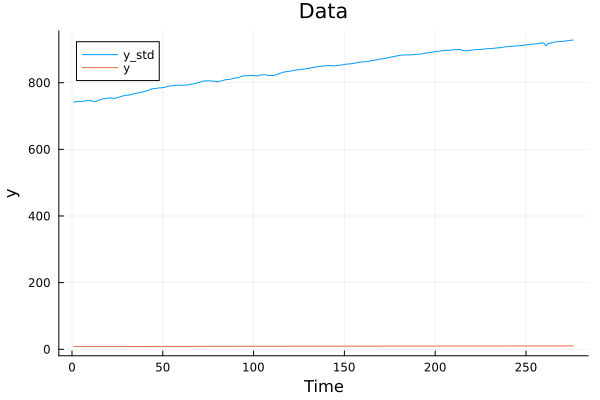

(1, 276)


6×6 Matrix{Float64}:
 100.0    0.0    0.0    0.0    0.0    0.0
   0.0  100.0    0.0    0.0    0.0    0.0
   0.0    0.0  100.0    0.0    0.0    0.0
   0.0    0.0    0.0  100.0    0.0    0.0
   0.0    0.0    0.0    0.0  100.0    0.0
   0.0    0.0    0.0    0.0    0.0  100.0

In [4]:
simulate = false



if simulate
    # True parameters
    ρ = 0.5
    λ_c = 0.2
    σ²_ε_y = 4*10e-5
    σ²_ξ_y = 4*10e-6
    σ²_κ_y = 6*10e-5

    θ_true = [ρ, λ_c, σ²_ε_y, σ²_ξ_y, σ²_κ_y]

    Random.seed!(123)
    n_obs = 200
    y, α = simulate_data(θ_true, cycle_order, n_obs)
    y_std, σʸ = standardize_data(y)

else
    # Load data
    data = CSV.read("data.csv", DataFrame)
    # Extract y 
    y = data.y
    # make y a matrix
    y = Matrix(y')
    # log transform y
    y = log.(y)
    println(size(y))
    y_std, σʸ = standardize_data(y)
    n_obs = length(y)
end


# plot data
plot(y_std[1,:], label="y_std", title="Standardized data", xlabel="Time", ylabel="y", legend=:topleft)
plot!(y[1,:], label="y", title="Data", xlabel="Time", ylabel="y", legend=:topleft)
display(plot!())

# Initial states
α0 = zeros(length(α_elements))
α0[1] = y[1]
P0 = 100*Matrix{Float64}(I, length(α_elements), length(α_elements))

## MCMC

In [5]:
θ_0 = [0.2, 0.3, 0.2, 0.01, 0.2]

θ_chain, θ_chain_init, α_draws = MCMC_estimation(y_std, prior_info, α0, P0, cycle_order, σʸ;
 iter_init = 20000, 
 burn_init = 10000,
 iter_rec = 15000,
burn_rec = 10000,
θ_init = θ_0,
ω = 0.01)

Initialization Phase 100%|███████████████████████████████| Time: 0:00:32


Initialization Acceptance Rate: 30.775000000000002%


Recursion Phase 100%|████████████████████████████████████| Time: 0:00:57


Recursion Acceptance Rate: 32.013333333333335%


([0.7409018379426527 0.07792587421864977 … 2.3816736637325332e-7 3.1351471700037074e-5; 0.7409018379426527 0.07792587421864977 … 2.3816736637325332e-7 3.1351471700037074e-5; … ; 0.7037518308508363 0.054100230513130294 … 1.830204176936697e-7 6.629219212595296e-5; 0.7037518308508363 0.054100230513130294 … 1.830204176936697e-7 6.629219212595296e-5], [0.1898681038496068 0.2627395286404675 … 0.009784686703676649 0.21009124475857938; 0.19110103621868832 0.30232655294455985 … 0.010196400295375744 0.22293085898999448; … ; 0.6619449209516697 0.10174902649640519 … 7.018036948000139e-7 4.316852710263513e-5; 0.6619449209516697 0.10174902649640519 … 7.018036948000139e-7 4.316852710263513e-5], [7.977966963810621 0.008912875639246032 … -0.20114635516277168 -0.004290940112423258; 7.79080876629644 0.017094928418043942 … -0.20443687997788818 0.09162197134182914; … ; 7.944027100771244 0.010732933246828225 … -0.08445621685151039 0.11290245298293655; 7.912781644171234 0.011753188350160926 … -0.427680856665

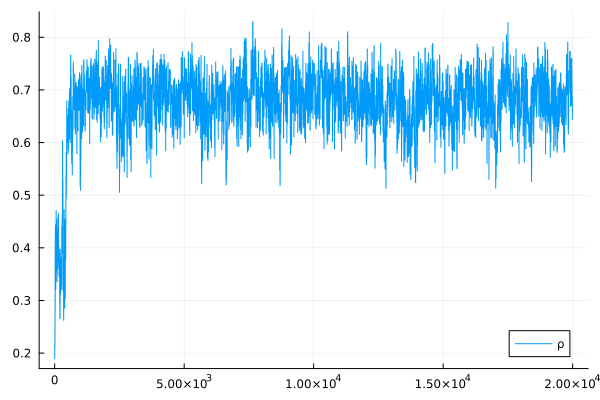

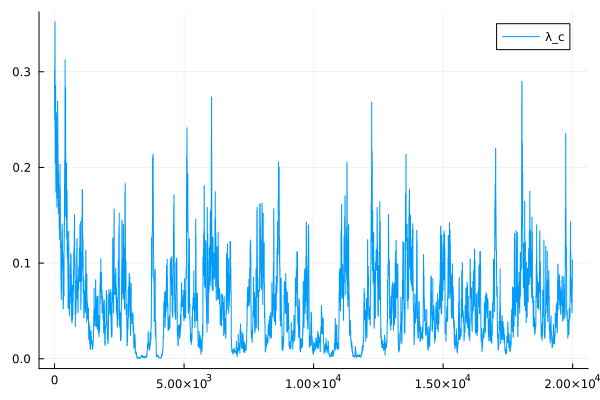

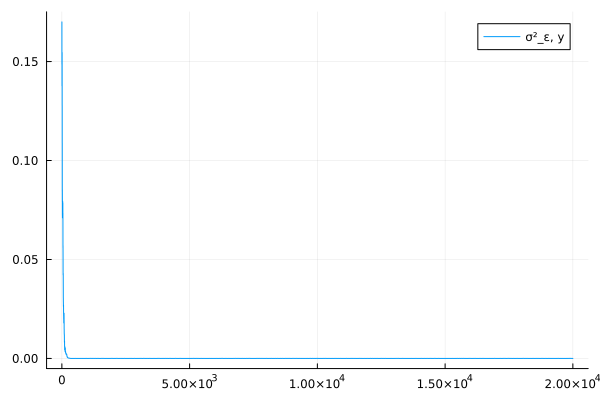

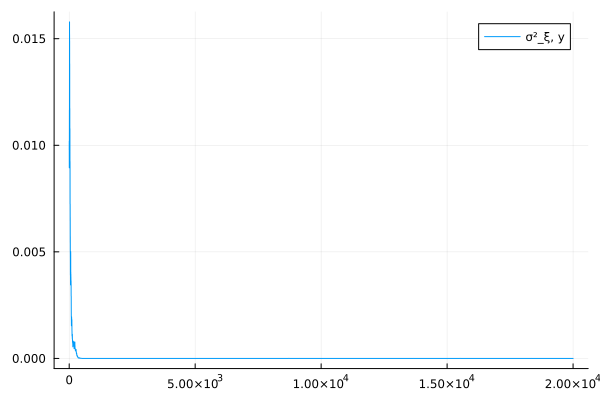

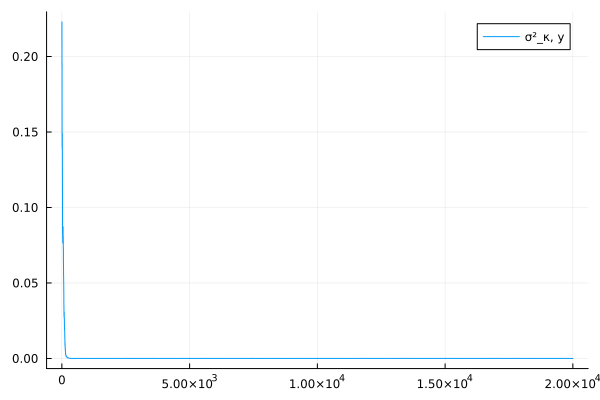

Initial chain shape: (20000, 5)


In [6]:
println("Initial chain shape: ", size(θ_chain_init))
#Print trace plot and add true value
for i in 1:size(θ_chain_init, 2)
    plot(θ_chain_init[:,i], label="$(θ_elements[i])")
    if simulate
        hline!([θ_true[i]], label="true $(θ_elements[i])")
    end
    display(plot!())
end

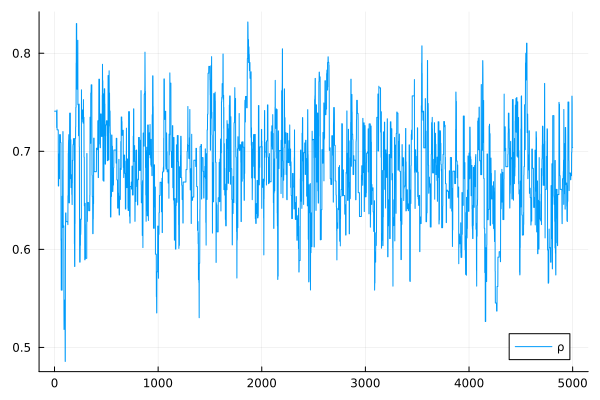

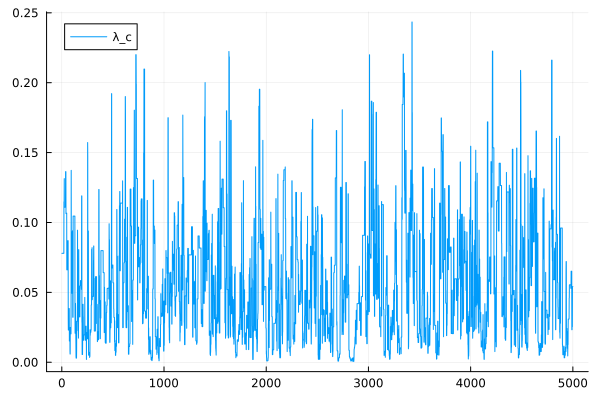

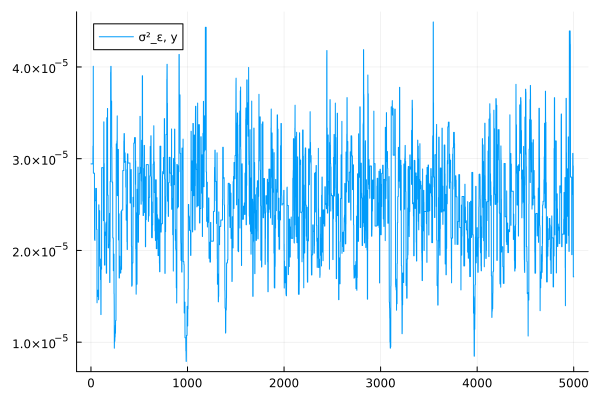

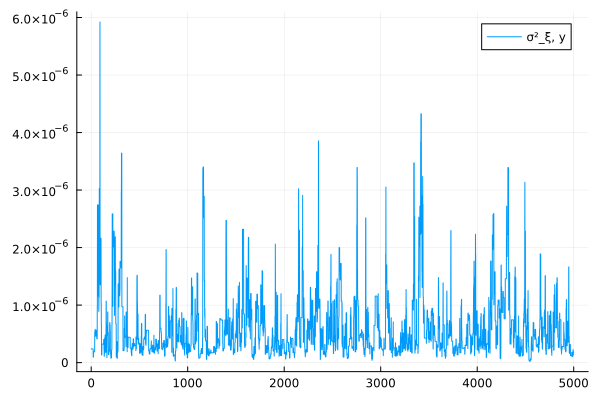

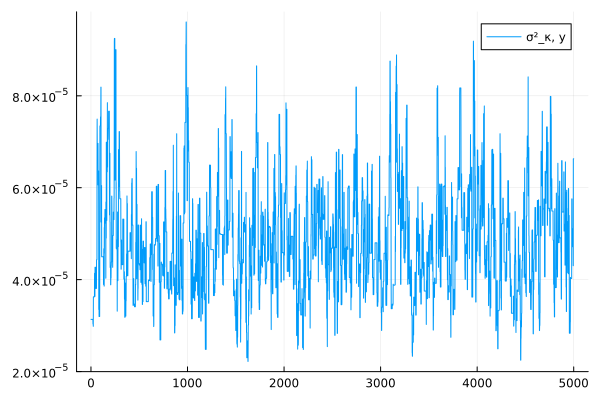

Rec chain shape: (5000, 5)


In [7]:
println("Rec chain shape: ", size(θ_chain))

#Print trace plot and add true value
for i in 1:size(θ_chain, 2)
    plot(θ_chain[:,i], label="$(θ_elements[i])")
    if simulate
        hline!([θ_true[i]], label="true $(θ_elements[i])")
    end
    display(plot!())
end



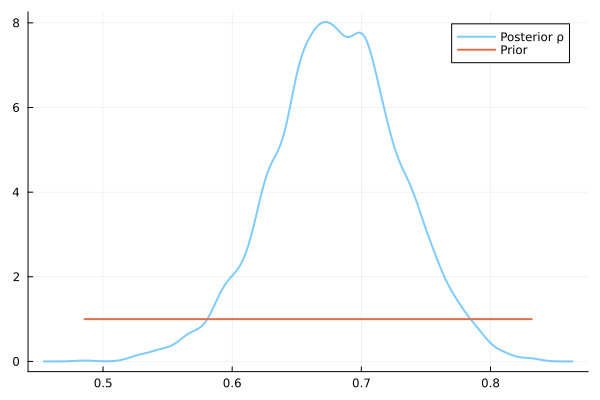

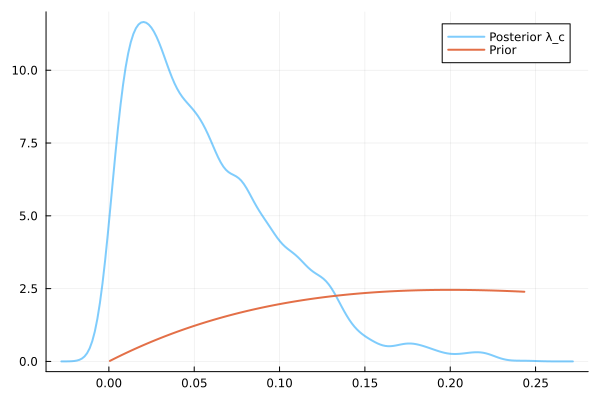

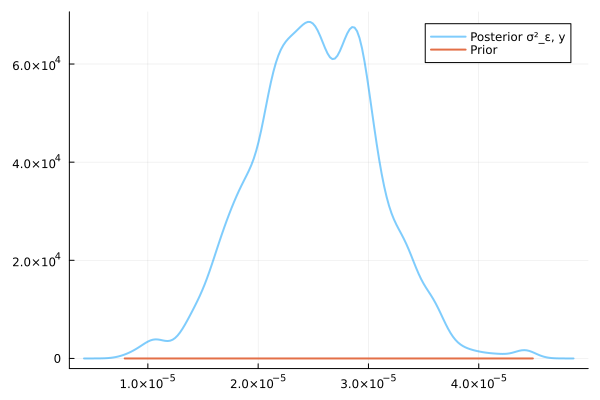

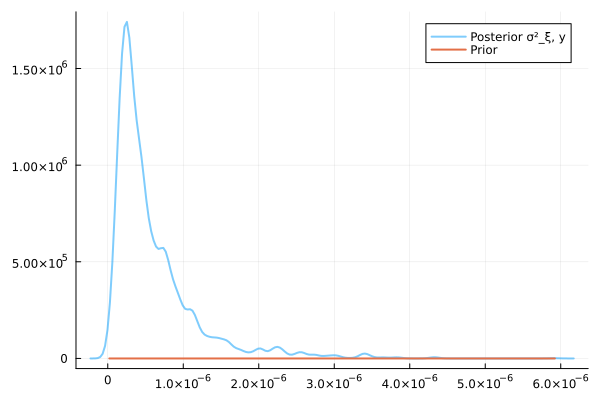

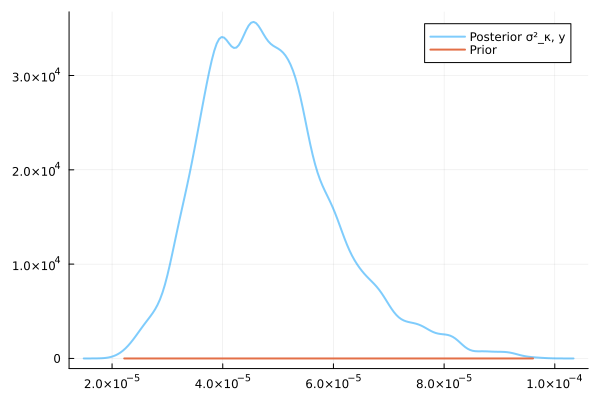

In [8]:

# Iterate through each parameter's chain
for i in 1:size(θ_chain, 2)
    # Plot kernel density estimate of the posterior
    density(θ_chain[:,i], label="Posterior $(θ_elements[i])", alpha=0.5, linewidth=2)

    # Prior distribution
    if prior_distributions[i] == "uniform"
        prior = Uniform(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    elseif prior_distributions[i] == "beta"
        prior = Beta(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    elseif prior_distributions[i] == "normal"
        prior = Normal(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    elseif prior_distributions[i] == "inverse gamma"
        prior = InverseGamma(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    end
    x_vals = range(minimum(θ_chain[:,i]), maximum(θ_chain[:,i]), length=100)
    plot!(x_vals, pdf.(prior, x_vals), label="Prior", linewidth=2)

    # True value
    if simulate
        vline!([θ_true[i]], label="True $(θ_elements[i])", linestyle=:dash, color=:red)
    end

    # Display the plot
    display(plot!())
end


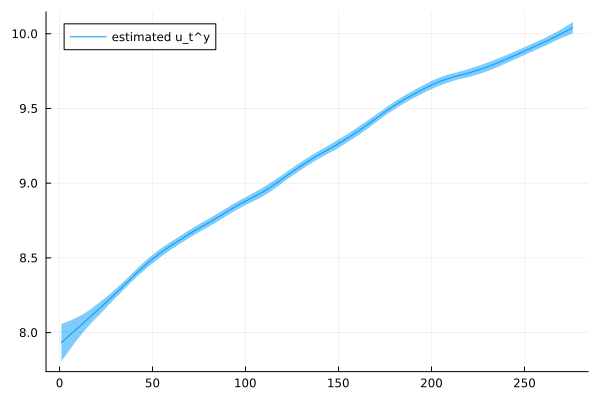

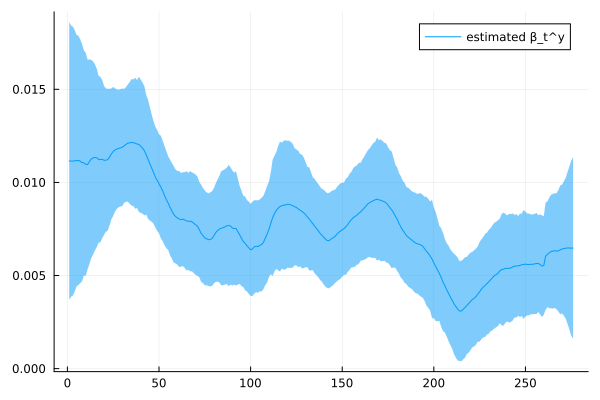

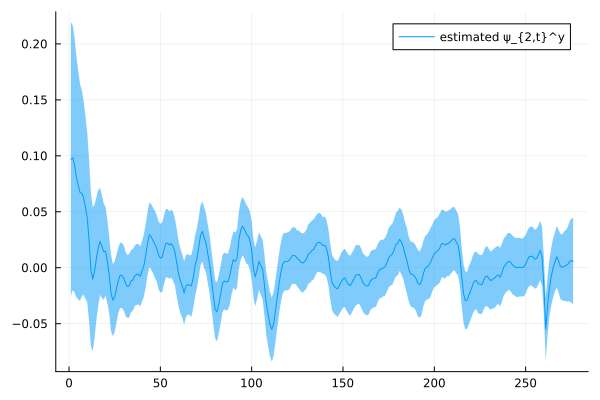

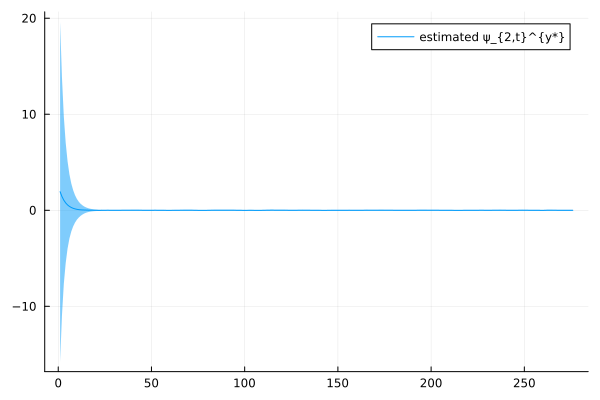

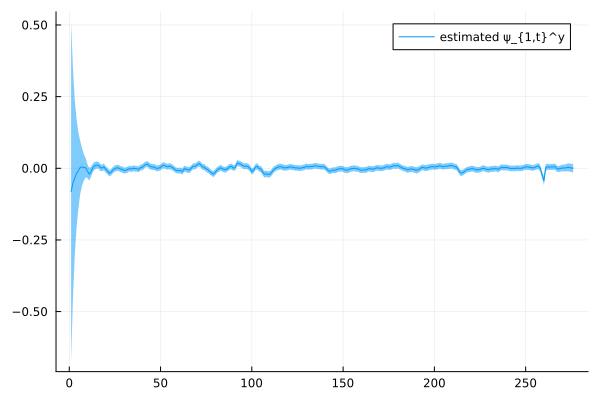

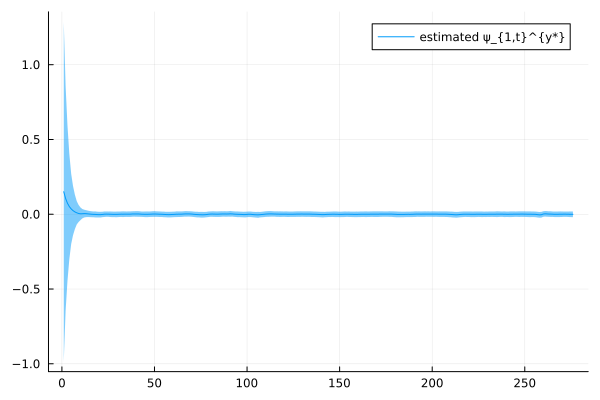

Mean of α_draws: (1, 6, 276)


In [9]:
# Compute the mean over iterations (dimension 1)
α_mean = mean(α_draws, dims=1)
println("Mean of α_draws: ", size(α_mean))

# Compute the 2.5% and 97.5% quantiles 
α_ci = mapslices(x -> quantile(x, [0.025, 0.975]), α_draws, dims=1)



# Plot true states, mean of states, and confidence intervals of states
for i in 1:size(α_mean, 2)
    plot(α_mean[1, i, :], ribbon=(α_ci[2, i, :] .- α_mean[1, i, :]), label="estimated $(α_elements[i])")
    if simulate
        plot!(α[i, :], label="true $(α_elements[i])")
    end
    display(plot!())
end


## MLE

In [10]:
# using Optim


# lower_bounds = [0.0, 0.0, 1e-12, 1e-12, 1e-12]
# upper_bounds = [1.0, 3.0, 3.0, 3.0, 3.0]
# θ_init = [0.5, 0.1, 4*10e-5, 4*10e-6, 6*10e-5]

# objective(θ) = neg_log_likelihood(θ, y, α0, P0, cycle_order, σʸ)
# res = optimize(objective, lower_bounds, upper_bounds, θ_init, Fminbox(BFGS()))
# θ_est = Optim.minimizer(res)

# # Print the results:
# println("MLE Results (with bounded optimization):")
# for (i, param_name) in enumerate(θ_elements)
#     println("Estimated $(param_name): $(θ_est[i])   (True value: $(θ_true[i]))")
# end
# println("Final negative log-likelihood: ", Optim.minimum(res))


In [11]:
# # estimate states
# LogL_diff, α_diff, P_diff = diffuse_kalman_filter(y, θ_est, α0, P0, cycle_order, σʸ,  true, false)

# #plot estimated states and true states
# for i in 1:size(α,2)
#     plot(α[:,i], label="true $(α_elements[i])")
#     plot!(α_diff[:,i], label="estimated $(α_elements[i])")
#     display(plot!())
# end

